# Topic Modelling

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from wordcloud import WordCloud, STOPWORDS


%matplotlib inline
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

import gensim, logging, warnings
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
stop_words.extend(['look', 'smell', 'taste', 'feel', 'overall', 'rdev', 'beer', 'beers','nice','adams', 'jan', 'feb', 'mar',
                  'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'ml', 'oz', 'date',
                  'alright', 'one', 'pour', 'pours', 'gluten', 'made', 'glass', 'one', 'bit', 'maybe', 'pretty',
                  'served', 'key', 'keg', 'good', 'wonder', 'mix', 'left', 'inch', 'american', 'style', 'similar'])

In [11]:
def clean_review(review):
    """takes in a review and does the following:
    1. removes the '\xa0'
    2. removes the '\n'
    3. performs the simple preprocess from gensim"""
    review = review.replace(u'\\xa0', '')
    review = review.replace('\\n', '')
    review = gensim.utils.simple_preprocess(str(review), deacc=True)
    review = [word for word in review if word not in stop_words]
    meta_lemmed = [lemmatizer.lemmatize(word) for word in review]
#     c = " ".join(str(x) for x in meta_lemmed)
#     cleaned.append(c)
    return meta_lemmed

In [25]:
df['clean_review'] = df['review'].apply(clean_review)

In [13]:
lemmatizer = WordNetLemmatizer()

In [24]:
df = pd.read_csv("data_files/ntop_beers.csv", index_col=0)

In [8]:
df.shape

(41869, 19)

In [9]:
df.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,key_words
7,6%,Winter,3.97,88.0,Pennsylvania Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Pennsylvania,St. Nikolaus Bock Bier,430,220,['3.9/5\xa0\xa0rDev -1.8%look: 4.25 | smell: 3...,German Bock,https://www.beeradvocate.com/beer/profile/125/...,3.989583,3.968750,3.687500,3.885417,"['dark', 'black', 'slight', 'tan', 'head', 'ro...",dark black slight tan head roasted barley good...
12,7%,Fall,4.01,89.0,Bierbrouwerij De Koningshoeven B.V.,https://cdn.beeradvocate.com/im/beers/101.jpg,Netherlands,La Trappe Bockbier,285,117,"[""4.15/5\xa0\xa0rDev +3.5%look: 4 | smell: 4 |...",German Bock,https://www.beeradvocate.com/beer/profile/184/...,4.080000,4.200000,4.020000,4.060000,"['deep', 'chestnut', 'ruby', 'slight', 'haze',...",deep chestnut ruby slight haze probably bottle...
17,6%,Winter,3.99,88.0,Millstream Brewing Company,https://cdn.beeradvocate.com/im/beers/101.jpg,Iowa,Schokolade Bock,180,105,['3.97/5\xa0\xa0rDev -0.5%look: 4 | smell: 3.7...,German Bock,https://www.beeradvocate.com/beer/profile/107/...,4.093750,3.916667,3.916667,4.062500,"['review', 'german', 'pilsner', 'figure', 'del...",review german pilsner figure delete erroneous ...
41,6.5%,Year-round,4.01,87.0,Aass Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Norway,Aass Bock,65,40,['2.83/5\xa0\xa0rDev -29.4%look: 3 | smell: 3 ...,German Bock,https://www.beeradvocate.com/beer/profile/185/...,4.150000,3.960000,3.910000,3.970000,"['light', 'brown', 'pour', 'earthy', 'edge', '...",light brown pour earthy edge thin head white a...
46,6%,Rotating,3.91,86.0,Perrin Brewing Co.,https://cdn.beeradvocate.com/im/beers/101.jpg,Michigan,Poop Your Pants Chocolate Bock,52,11,['3.36/5\xa0\xa0rDev -14.1%look: 3.25 | smell:...,German Bock,https://www.beeradvocate.com/beer/profile/2995...,3.931818,3.909091,3.795455,3.863636,"['including', 'tax', 'six', 'pack', 'meijer', ...",including tax six pack meijer birch run mi und...


In [41]:
df.iloc[0]['review']

'[\'3.9/5\\xa0\\xa0rDev -1.8%look: 4.25 | smell: 3 | taste: 4.25 | feel: 3.75 | overall: 4.25Dark black beer with slight tan head, roasted barley smell, good roast taste that fades with little bitterness actually very pleasant on the palate, good light body and carbonation\\xa0180 charactersCodyBasden, May 20, 2019\', \'4.12/5\\xa0\\xa0rDev +3.8%look: 4.25 | smell: 3.5 | taste: 4.5 | feel: 3.75 | overall: 4.25Look: dark, chocolatey to deep brick read. Thin head with slight lacing.\\nSmell: hoppy and rich, like your favorite pub.\\nTaste: fresh, rich hoppy. Nice and smooth.\\nFeel: slight tang. Rich and smooth.\\nOverall: Penn brewery’s bock is quite fine. Easy to drink and very distinctive, rich flavor.\\xa0293 charactersBishopJ, Jan 12, 2019\', \'3.77/5\\xa0\\xa0rDev -5%look: 4 | smell: 3.75 | taste: 3.75 | feel: 3.75 | overall: 3.75A - Dark amber to orange brown in color with nice clarity and sticky lacing.\\n\\nS - Toasted caramel malt with some spice/cinnamon and a small hit of aci

In [26]:
id2word = corpora.Dictionary(df['clean_review'])

In [27]:
corpus = [id2word.doc2bow(text) for text in df['clean_review']]

In [28]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, random_state=42,
                                             workers=5, passes=10)

In [29]:
pprint(lda_model.print_topics())

[(0,
  '0.028*"chocolate" + 0.027*"coffee" + 0.024*"dark" + 0.017*"black" + '
  '0.015*"head" + 0.014*"malt" + 0.014*"stout" + 0.014*"roasted" + '
  '0.012*"flavor" + 0.011*"brown"'),
 (1,
  '0.019*"dark" + 0.016*"brown" + 0.016*"sweet" + 0.013*"head" + '
  '0.013*"caramel" + 0.012*"fruit" + 0.011*"malt" + 0.011*"flavor" + '
  '0.009*"sugar" + 0.009*"alcohol"'),
 (2,
  '0.021*"orange" + 0.014*"fruit" + 0.013*"head" + 0.012*"citrus" + '
  '0.012*"tropical" + 0.011*"pineapple" + 0.011*"mango" + 0.011*"hop" + '
  '0.010*"hazy" + 0.010*"flavor"'),
 (3,
  '0.036*"light" + 0.018*"head" + 0.017*"white" + 0.017*"malt" + 0.016*"hop" + '
  '0.015*"flavor" + 0.015*"aroma" + 0.014*"carbonation" + 0.012*"moderate" + '
  '0.012*"medium"'),
 (4,
  '0.102*"raspberry" + 0.013*"tart" + 0.012*"pink" + 0.012*"gose" + '
  '0.010*"salt" + 0.009*"like" + 0.009*"head" + 0.007*"light" + 0.007*"fruit" '
  '+ 0.007*"sour"'),
 (5,
  '0.018*"sour" + 0.014*"tart" + 0.013*"funk" + 0.012*"white" + 0.011*"light" '
  '

In [91]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')
print(coherence_model_lda.get_coherence())

0.39062168811270176


Maybe do the test to find best number of topics

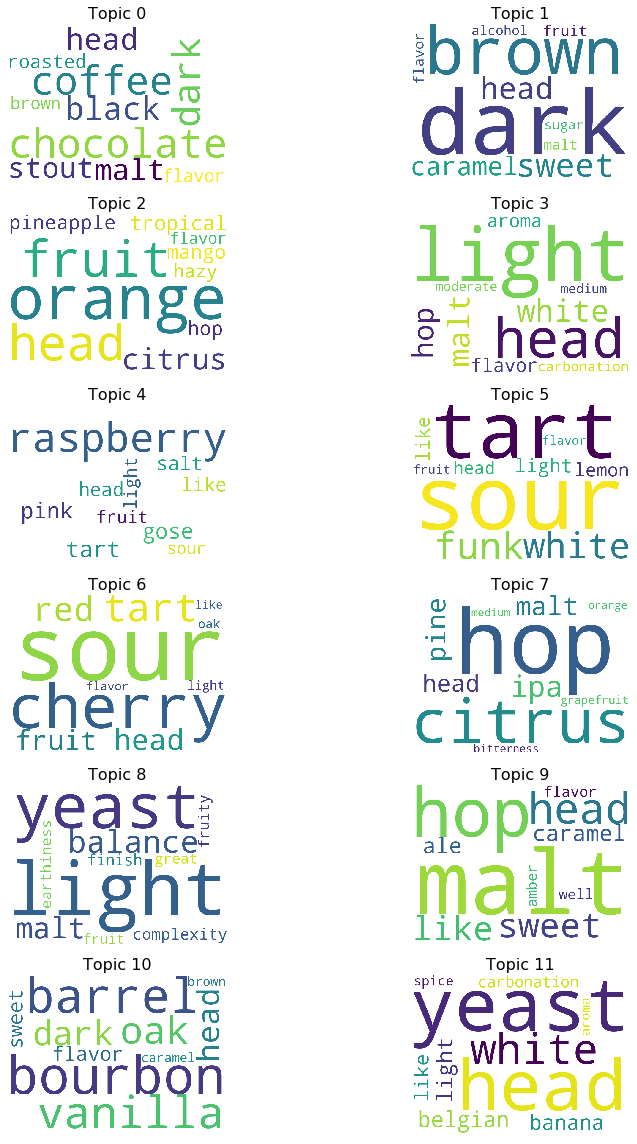

In [30]:
cloud = WordCloud(max_words= 100,
               width = 744, 
               height = 544,
               background_color ='white',
               stopwords=stop_words, 
               contour_width=3, 
               contour_color='steelblue',
               min_font_size = 10)

topics = lda_model.show_topics(num_topics=12,formatted=False)

fig, axes = plt.subplots(6, 2, figsize=(14,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [39]:
topics

[(4,
  [('raspberry', 0.12302851),
   ('head', 0.007846165),
   ('like', 0.007612669),
   ('pink', 0.0071502896),
   ('tart', 0.0071268394),
   ('light', 0.0058516064),
   ('spruce', 0.0056587257),
   ('finish', 0.0053556934),
   ('fresh', 0.005268374),
   ('great', 0.0051367246)]),
 (1,
  [('dark', 0.01843606),
   ('brown', 0.017062347),
   ('sweet', 0.016398551),
   ('head', 0.013278934),
   ('caramel', 0.012869381),
   ('flavor', 0.011623474),
   ('malt', 0.010786349),
   ('fruit', 0.009985138),
   ('cinnamon', 0.009626598),
   ('spice', 0.009585822)]),
 (5,
  [('sour', 0.017484792),
   ('tart', 0.014173787),
   ('funk', 0.012378203),
   ('like', 0.011736799),
   ('light', 0.011028305),
   ('white', 0.01091564),
   ('lemon', 0.010705426),
   ('flavor', 0.009114683),
   ('head', 0.008668787),
   ('really', 0.00852974)]),
 (10,
  [('bourbon', 0.028893126),
   ('barrel', 0.023705266),
   ('vanilla', 0.021680865),
   ('oak', 0.014977193),
   ('dark', 0.013147385),
   ('head', 0.01000624

In [132]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)
# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

In [63]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.104139  0.066407       1        1  21.433853
7     -0.005297 -0.029037       2        1  13.967826
2      0.012338 -0.038746       3        1  10.868725
9     -0.072567 -0.010558       4        1  10.212069
1     -0.066356  0.072541       5        1   8.379511
10    -0.110637  0.091659       6        1   8.009496
5      0.021027 -0.040391       7        1   6.834843
11     0.021904 -0.015221       8        1   5.697142
6     -0.002126  0.005768       9        1   5.666282
3      0.063449 -0.031335      10        1   5.665904
8      0.256689  0.087077      11        1   2.551501
4     -0.014286 -0.158167      12        1   0.712855, topic_info=      Category           Freq        Term          Total  loglift  logprob
116    Default   75597.000000      coffee   75597.000000  30.0000  30.0000
100    Default   87850.000000   chocolate   87850.000000  29.0000  29.0000
292    Default  133779.000000       light  133779.000000  28.0000  28.0000
2361   Default   30367.000000     bourbon   30367.000000  27.0000  27.0000
469    Default   40017.000000        sour   40017.000000  26.0000  26.0000
253    Default  127955.000000         hop  127955.000000  25.0000  25.0000
137    Default  113705.000000        dark  113705.000000  24.0000  24.0000
1262   Default   33404.000000        tart   33404.000000  23.0000  23.0000
1212   Default   12799.000000   raspberry   12799.000000  22.0000  22.0000
2356   Default   30949.000000      barrel   30949.000000  21.0000  21.0000
547    Default   48175.000000     vanilla   48175.000000  20.0000  20.0000
801    Default   41824.000000         ipa   41824.000000  19.0000  19.0000
573    Default   33200.000000       yeast   33200.000000  18.0000  18.0000
956    Default   41520.000000       stout   41520.000000  17.0000  17.0000
562    Default   78444.000000       white   78444.000000  16.0000  16.0000
2398   Default   32605.000000         oak   32605.000000  15.0000  15.0000
76     Default   65253.000000       brown   65253.000000  14.0000  14.0000
368    Default   67719.000000      orange   67719.000000  13.0000  13.0000
222    Default   85582.000000       fruit   85582.000000  12.0000  12.0000
99     Default   24023.000000      cherry   24023.000000  11.0000  11.0000
652    Default   67285.000000      citrus   67285.000000  10.0000  10.0000
312    Default  139558.000000        malt  139558.000000   9.0000   9.0000
430    Default   40955.000000     roasted   40955.000000   8.0000   8.0000
55     Default   53156.000000       black   53156.000000   7.0000   7.0000
40     Default   29444.000000     balance   29444.000000   6.0000   6.0000
2335   Default   32311.000000        pine   32311.000000   5.0000   5.0000
415    Default   23953.000000         red   23953.000000   4.0000   4.0000
199    Default   98862.000000      finish   98862.000000   3.0000   3.0000
8433   Default   35669.000000  grapefruit   35669.000000   2.0000   2.0000
332    Default   37082.000000    moderate   37082.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
14693  Topic12     152.409988  watermelon     960.829773   3.1024  -6.4153
2827   Topic12     171.644348        seed    1269.514404   2.9427  -6.2965
1531   Topic12     177.507568        rose    1422.327148   2.8626  -6.2629
9527   Topic12     124.641006      weisse     669.936584   3.2619  -6.6165
1215   Topic12     457.120697  refreshing   14255.234375   1.5037  -5.3170
4495   Topic12      87.192940       jelly     336.332733   3.5937  -6.9738
1037   Topic12     379.592010       berry    9844.510742   1.6881  -5.5028
217    Topic12     511.010315       fresh   21957.267578   1.1832  -5.2055
469    Topic12     623.395020        sour   40017.093750   0.7818  -5.0067
1818   Topic12     384.451935    tartness   12007.671875   1.5022  -5.4901
294    Topic12     852.255249        like  108228.9

In [131]:
import pickle
pickle.dump(vis, open('lda_vis.p', 'wb'))

In [66]:
pyLDAvis.save_html(vis, 'lda_vis.html')

In [67]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 12
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:9,0], y=tsne_lda[:9,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40916 samples in 0.048s...
[t-SNE] Computed neighbors for 40916 samples in 1.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40916
[t-SNE] Computed conditional probabilities for sample 2000 / 40916
[t-SNE] Computed conditional probabilities for sample 3000 / 40916
[t-SNE] Computed conditional probabilities for sample 4000 / 40916
[t-SNE] Computed conditional probabilities for sample 5000 / 40916
[t-SNE] Computed conditional probabilities for sample 6000 / 40916
[t-SNE] Computed conditional probabilities for sample 7000 / 40916
[t-SNE] Computed conditional probabilities for sample 8000 / 40916
[t-SNE] Computed conditional probabilities for sample 9000 / 40916
[t-SNE] Computed conditional probabilities for sample 10000 / 40916
[t-SNE] Computed conditional probabilities for sample 11000 / 40916
[t-SNE] Computed conditional probabilities for sample 12000 / 40916
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

IndexError: index 10 is out of bounds for axis 0 with size 10

In [129]:
mycolors

array(['#be03fd', '#7af9ab', '#75bbfd', '#ff796c', '#8c000f', '#fac205',
       '#80013f', '#fd411e', '#01f9c6', '#ffb16d', '#fdff52', '#fe46a5'],
      dtype='<U7')

In [114]:
mycolors = np.delete(mycolors,0)

In [127]:
mycolors = np.append(mycolors, '#fe46a5')

In [90]:
# Plot the Topic Clusters using Bokeh
topic_num = np.argmax(arr, axis=1)
output_notebook()
n_topics = 12
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

In [128]:
# Plot the Topic Clusters using Bokeh
topic_num = np.argmax(arr, axis=1)
output_notebook()
n_topics = 12
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

In [34]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['clean_review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sent_topics_df = pd.concat([df, sent_topics_df], axis=1)
    return(sent_topics_df)

In [35]:
df.reset_index(drop=True, inplace=True)

In [36]:
df_dominant_topic = format_topics_sentences(ldamodel=lda_model)

In [38]:
df_dominant_topic.to_csv('data_files/top_top_beers.csv')

In [40]:
df_dominant_topic.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,...,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,key_words,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,6%,Winter,3.97,88.0,Pennsylvania Brewing Company,https://cdn.beeradvocate.com/im/beers/2272.jpg,Pennsylvania,St. Nikolaus Bock Bier,430,220,...,https://www.beeradvocate.com/beer/profile/125/...,3.989583,3.968750,3.687500,3.885417,"[dark, black, slight, tan, head, roasted, barl...",dark black slight tan head roasted barley good...,1.0,0.3741,"dark, brown, sweet, head, caramel, fruit, malt..."
1,7%,Fall,4.01,89.0,Bierbrouwerij De Koningshoeven B.V.,https://cdn.beeradvocate.com/im/beers/20299.jpg,Netherlands,La Trappe Bockbier,285,117,...,https://www.beeradvocate.com/beer/profile/184/...,4.080000,4.200000,4.020000,4.060000,"[deep, chestnut, ruby, slight, haze, probably,...",deep chestnut ruby slight haze probably bottle...,1.0,0.5130,"dark, brown, sweet, head, caramel, fruit, malt..."
2,6%,Winter,3.99,88.0,Millstream Brewing Company,https://cdn.beeradvocate.com/im/beers/7904.jpg,Iowa,Schokolade Bock,180,105,...,https://www.beeradvocate.com/beer/profile/107/...,4.093750,3.916667,3.916667,4.062500,"[review, german, pilsner, figure, delete, erro...",review german pilsner figure delete erroneous ...,0.0,0.4328,"chocolate, coffee, dark, black, head, malt, st..."
3,6.5%,Year-round,4.01,87.0,Aass Brewery,https://cdn.beeradvocate.com/im/beers/664.jpg,Norway,Aass Bock,65,40,...,https://www.beeradvocate.com/beer/profile/185/...,4.150000,3.960000,3.910000,3.970000,"[light, brown, earthy, edge, thin, head, white...",light brown pour earthy edge thin head white a...,9.0,0.7236,"malt, hop, head, sweet, like, caramel, ale, fl..."
4,6%,Rotating,3.91,86.0,Perrin Brewing Co.,NaN,Michigan,Poop Your Pants Chocolate Bock,52,11,...,https://www.beeradvocate.com/beer/profile/2995...,3.931818,3.909091,3.795455,3.863636,"[including, tax, six, pack, meijer, birch, run...",including tax six pack meijer birch run mi und...,0.0,0.5977,"chocolate, coffee, dark, black, head, malt, st..."


In [58]:
df_dominant_topic.loc[df_dominant_topic.name == 'St. Nikolaus Bock Bier'].index

Int64Index([0], dtype='int64')

In [51]:
df_dominant_topic.iloc[0]['Dominant_Topic']

1.0

In [62]:
df_dominant_topic.loc[df_dominant_topic.name == 'St. Nikolaus Bock Bier', 'Dominant_Topic'].values[0]

1.0

In [63]:
words = []
for i in range(len(topics)):
#     words = []
    words.append(topics[i][1][1][0])
    print(words)

['brown']
['brown', 'head']
['brown', 'head', 'coffee']
['brown', 'head', 'coffee', 'head']
['brown', 'head', 'coffee', 'head', 'hop']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit', 'cherry']
['brown', 'head', 'coffee', 'head', 'hop', 'citrus', 'head', 'fruit', 'cherry', 'tart']


In [54]:
cloud = WordCloud(max_words= 100,
               width = 744, 
               height = 544,
               background_color ='white',
               stopwords=stop_words, 
               contour_width=3, 
               contour_color='steelblue',
               min_font_size = 10)

topics = lda_model.show_topics(formatted=False)


for i in range(len(topics)):
    words = []
    words.append(topics[i][1][1][0])

cloud.generate_from_frequencies(topics, max_font_size=300)

# fig, axes = plt.subplots(5, 2, figsize=(14,16), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

plt.figure()
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')

TypeError: expected string or bytes-like object